In [1]:
import cv2
import numpy as np
import os
from scipy.interpolate import interp1d
from pyefd import elliptic_fourier_descriptors
import matplotlib.pyplot as plt
import statistics

In [2]:
%matplotlib inline

In [3]:
# All Requirdef read_images_and_extract_contours_single_image(img_location):

def read_image_and_extract_contour(img_location):
    """Read an image from a given path and extract its largest external contour."""

    image = cv2.imread(img_location)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        # Find the largest contour
        contour = max(contours, key=cv2.contourArea)
        contour = contour.squeeze()  # Remove unnecessary dimensions
        return normalize_contour_points(contour)
    else:
        return None  # Return None if no contours are found

def normalize_contour_points(contour):
    """Normalize contour points to a fixed number for consistency."""
    N = 250
    contour_length = np.linspace(0, 1, len(contour))
    normalized_length = np.linspace(0, 1, N)
    interp_func_x = interp1d(contour_length, contour[:, 0], kind='linear')
    interp_func_y = interp1d(contour_length, contour[:, 1], kind='linear')
    normalized_contour = np.vstack((interp_func_x(normalized_length), interp_func_y(normalized_length))).T
    return normalized_contour

def compute_first_10_harmonics(contour, order=30):
    """Compute Fourier coefficients and return the first 10 harmonics."""
    coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
    first_10_harmonics = coeffs[:10]  # Extract the first 10 harmonics
    return first_10_harmonics

def show_image(image_path):
    """Display an image."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_image)
    plt.title(image_path)
    plt.axis('off')
    plt.show()


def plot_harmonic_distribution(harmonics):
    """Plot the distribution of the first 10 harmonic or coefficients as magnitudes."""
    # Compute magnitudes for each harmonic (A_n, B_n, C_n, D_n)
    magnitudes = np.linalg.norm(harmonics, axis=1)  # Calculate sqrt(A_n^2 + B_n^2 + C_n^2 + D_n^2)
    
    # Create a plot
    plt.figure(figsize=(8, 5))
    harmonic_indices = np.arange(1, len(magnitudes) + 1)
    plt.bar(harmonic_indices, magnitudes, color='skyblue', alpha=0.7)

    # Add labels and title
    plt.xlabel('Harmonic Number')
    plt.ylabel('Magnitude')
    plt.title('Distribution of the First 10 Harmonics')
    plt.xticks(harmonic_indices)

    # Show the plot
    plt.show()


def compute_S_only_positive(harmonics, m, epsilon=1e-10):
    """
    Compute the separator S by multiplying the magnitude of each harmonic by h^m 
    and summing the values over the first 10 harmonics.
    
    harmonics: array of Fourier coefficients (first 10 harmonics), 
               where each harmonic has 4 components (A, B, C, D).
    m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3).
    epsilon: a small constant to ensure positive magnitudes (default: 1e-10).
    
    Returns a single scalar value for S.
    """
    S = 0
    for h in range(1, 11):  # Loop over the first 10 harmonics (h starts from 1 to 10)
        # Get the Fourier coefficients (A, B, C, D) for the h-th harmonic
        A, B, C, D = harmonics[h - 1]
        
        
        # Compute the magnitude of the harmonic, ensuring it's positive
        magnitude = np.sqrt(A**2 + B**2 + C**2 + D**2)
        
        # Ensure the magnitude is positive by adding a small epsilon if needed
        magnitude = np.abs(magnitude) + epsilon
        
        # Compute the contribution to S (magnitude * h^m)
        S += magnitude * (h ** m)
        
    return S

def calculate_separator_suggested_change(efd_coeffs, m=3):
    # Extract the first 10 harmonics (assuming 4 coefficients per harmonic)
    first_10_harmonics = efd_coeffs[:10]

    # Calculate magnitudes for each harmonic (A, B, C, D)
    magnitudes = np.sqrt(np.sum(np.square(first_10_harmonics), axis=1))  # Compute magnitude for each harmonic

    # Generate harmonic indices, starting from 1 to 10
    harmonic_indices = np.arange(1, 11)

    # Calculate the separator value (sum of weighted magnitudes)
    separator_value = np.sum(magnitudes * np.power(harmonic_indices, m))

    return separator_value


In [4]:
# This Cell section just visualizes the extracted contours

def read_image_and_visualize_contour(img_location):
    """Read an image from a given path and extract its largest external contour."""

    image = cv2.imread(img_location)
    contours_list = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        # Find the largest contour
        contour = max(contours, key=cv2.contourArea)
        contour = contour.squeeze()  # Remove unnecessary dimensions

        # Normalize the contour points
        normalized_contour = normalize_contour_points(contour)

        # Append the normalized contour to the list
        contours_list.append(normalized_contour)

        # Visualize the contour on the original image
        visualize_contour(image, normalized_contour)

    return contours_list

def visualize_contour(image, contour):
    """Visualize the contour on the image using matplotlib."""
    # Convert image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image_rgb)
    
    # Plot the contour on the image
    plt.plot(contour[:, 0], contour[:, 1], color='red', linewidth=2)  # Red contour line
    
    plt.title("Extracted Contour")
    plt.axis('off')  # Hide axes
    plt.show()

def normalize_contour_points(contour):
    """Normalize contour points for visualization (optional)."""
    # This function could be useful for contour normalization
    # Example: Scaling or translating points to some standard size
    return contour

In [5]:
# Initialize lists to store separator values
separator_values_compute_s = []
separator_values_suggested_change = []

In [6]:
# Read in all images of a folder and visualize accordingly

def process_images_in_folder(folder_path):
    """Process all images in a given folder, extract contours, compute harmonics, and calculate separator values."""
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):  # Add more image formats if needed
            img_location = os.path.join(folder_path, filename)
            print(f"Processing image: {img_location}")

            # Read image and extract contour
            contour = read_image_and_extract_contour(img_location)

            if contour is not None:
                # Visualize the contour
                read_image_and_visualize_contour(img_location)

                # Compute the first 10 harmonics                
                harmonics = compute_first_10_harmonics(contour)

                # Plot the harmonic distribution
                plot_harmonic_distribution(harmonics)

                # Calculate separator values
                S_compute_s = compute_S_only_positive(harmonics, m=3)
                print(f"S (computed): {S_compute_s}")

                S_suggested_change = calculate_separator_suggested_change(harmonics, m=3)
                print(f"S (suggested change): {S_suggested_change}")

                # Store separator values
                separator_values_compute_s.append(S_compute_s)
                separator_values_suggested_change.append(S_suggested_change)

                # Visualize the contour
                # read_image_and_visualize_contour(img_location)
                print("------------------------------------------------------------")

In [7]:
# Folder path containing images
folder_path = "/home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck"  # Change this to your folder path

Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_110_Potato_9.png


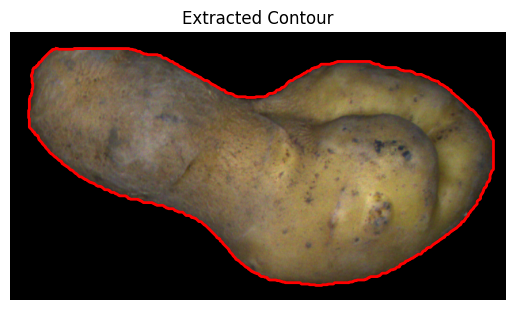

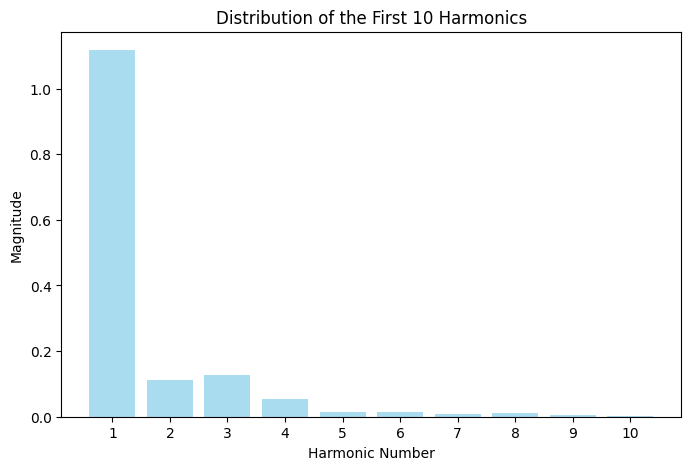

S (computed): 28.886630338949765
S (suggested change): 28.886630036449766
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_248_Potato_6.png


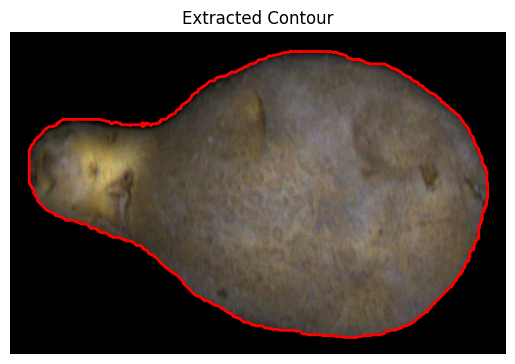

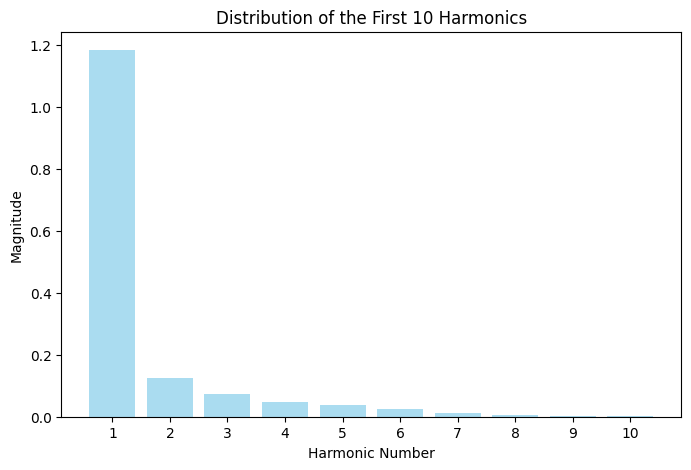

S (computed): 26.851494033703617
S (suggested change): 26.851493731203618
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_110_Potato_5.png


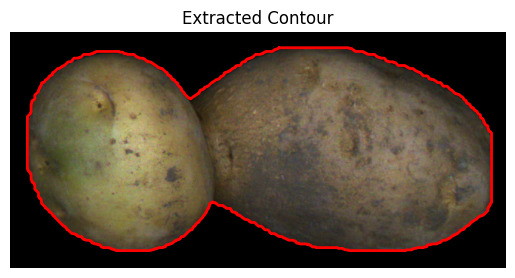

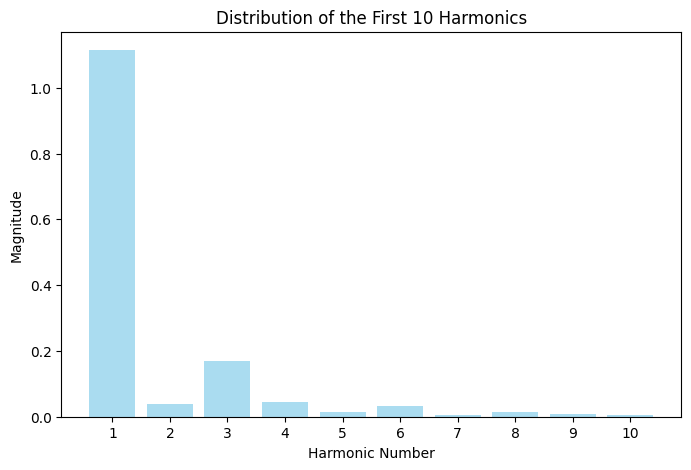

S (computed): 39.634093567187605
S (suggested change): 39.634093264687614
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_152_5.png


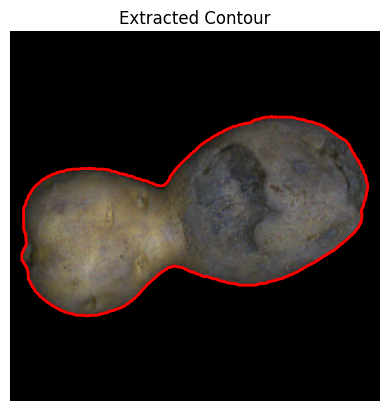

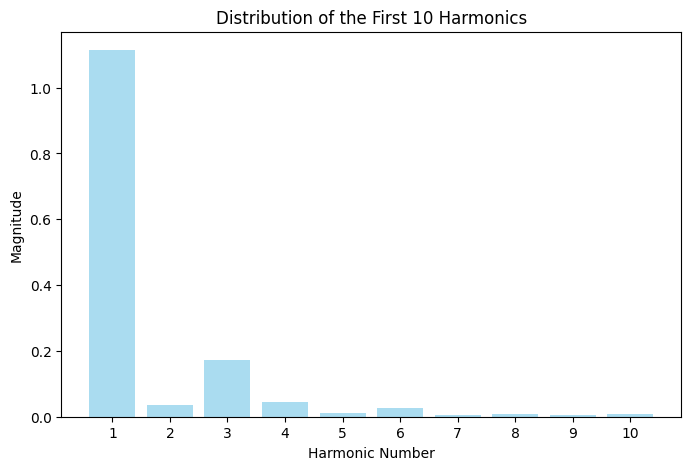

S (computed): 33.239338227533544
S (suggested change): 33.23933792503355
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_130_4.png


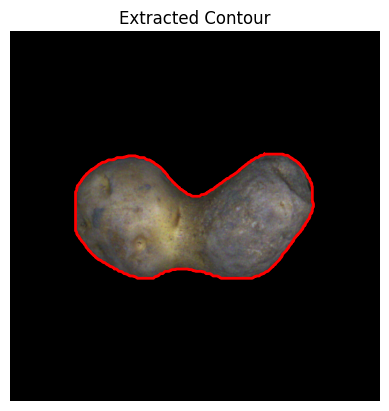

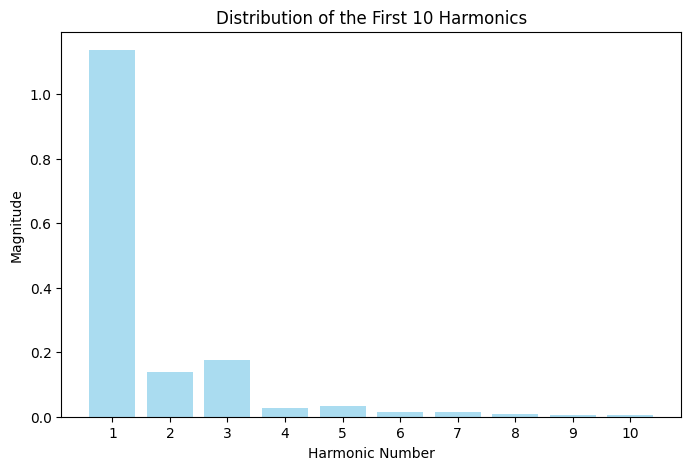

S (computed): 32.48121526955382
S (suggested change): 32.48121496705382
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_152_9.png


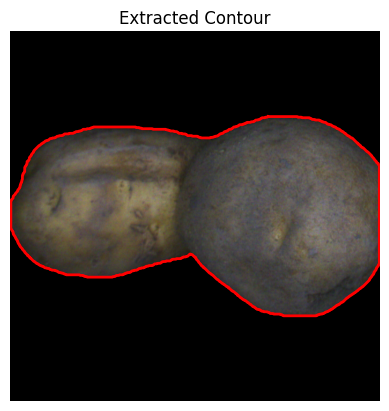

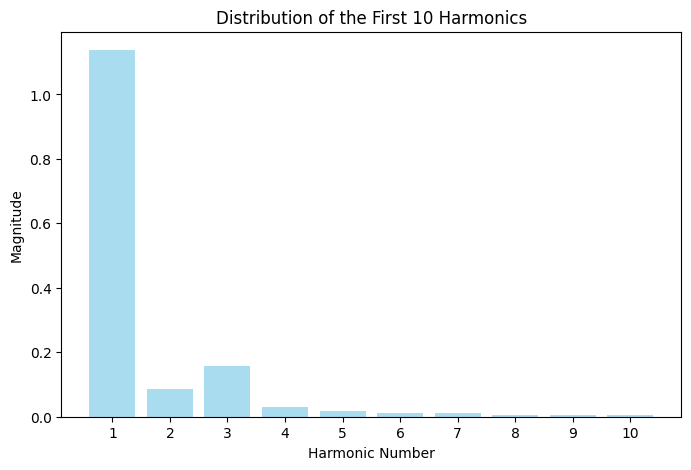

S (computed): 30.371837677489555
S (suggested change): 30.37183737498956
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_154_0.png


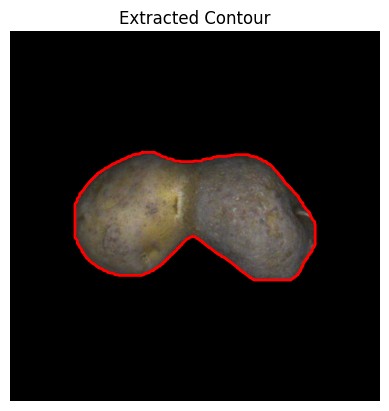

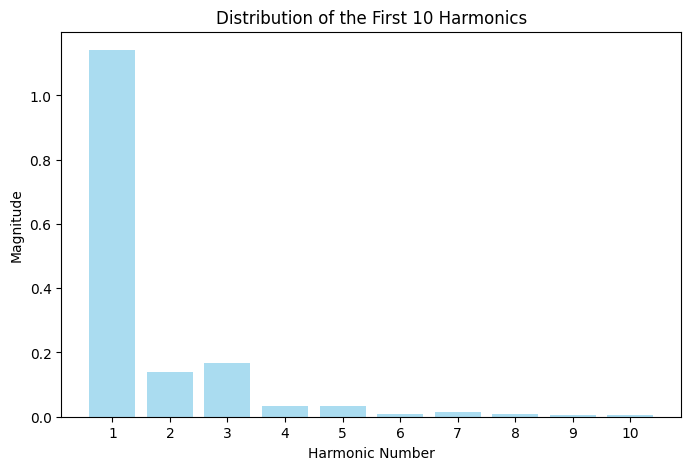

S (computed): 33.75352365487885
S (suggested change): 33.75352335237884
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_168_2.png


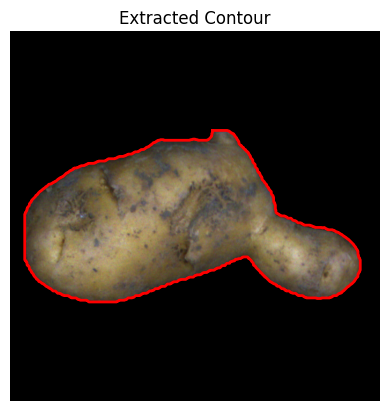

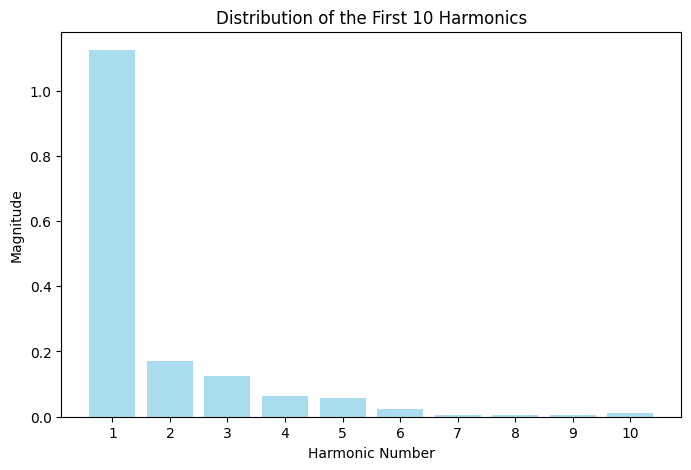

S (computed): 41.076679300749866
S (suggested change): 41.07667899824986
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_108_5.png


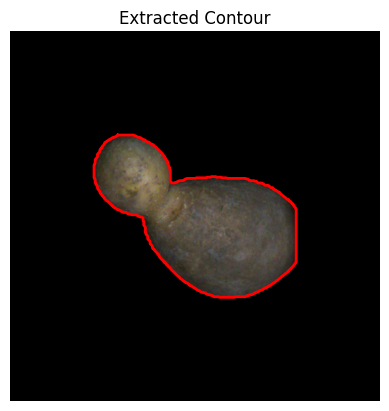

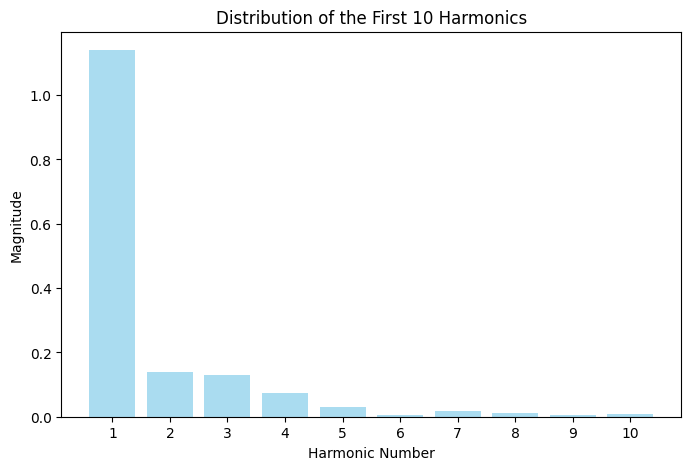

S (computed): 39.89205928855663
S (suggested change): 39.89205898605663
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_18_1.png


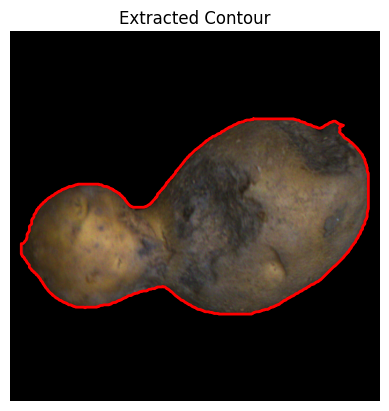

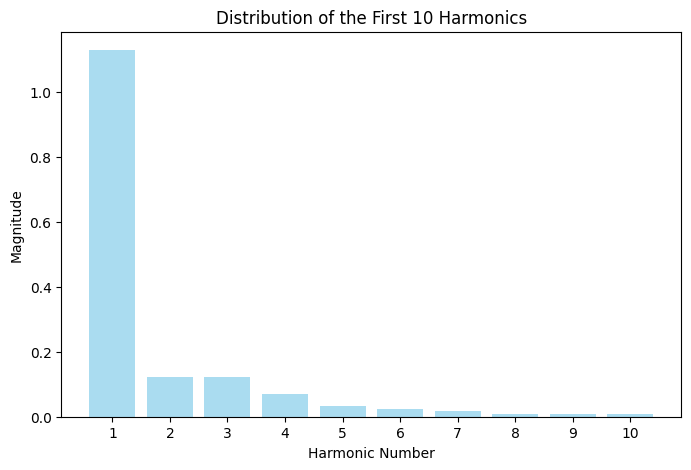

S (computed): 42.92176978521502
S (suggested change): 42.92176948271502
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_122_1.png


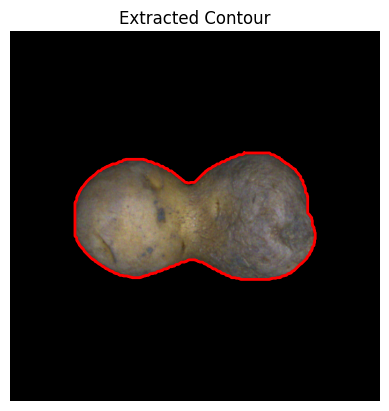

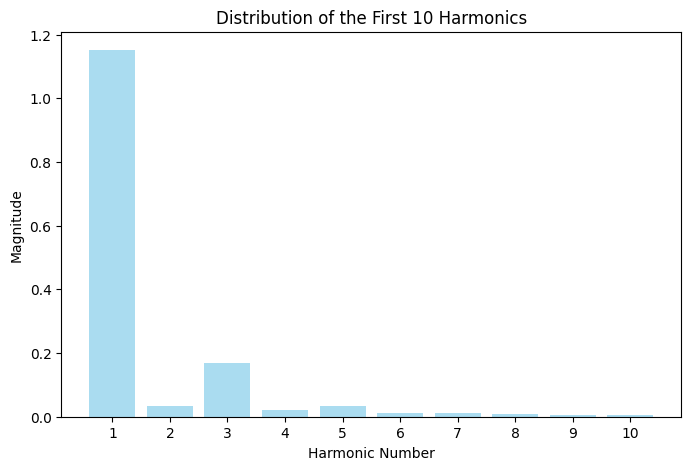

S (computed): 31.585310740147122
S (suggested change): 31.585310437647127
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_130_0.png


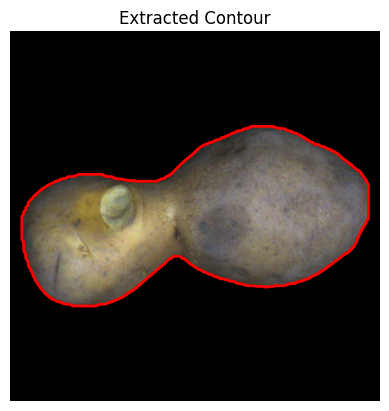

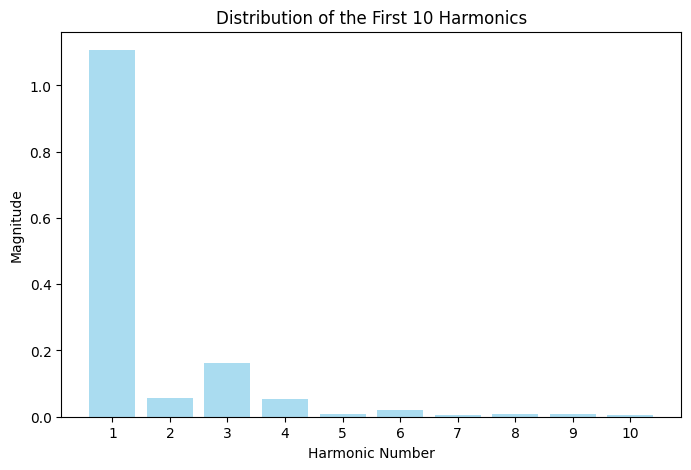

S (computed): 32.76013925187527
S (suggested change): 32.76013894937527
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_158_14.png


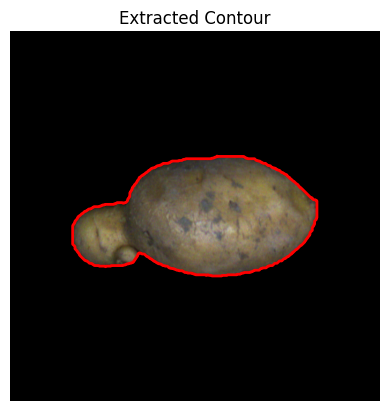

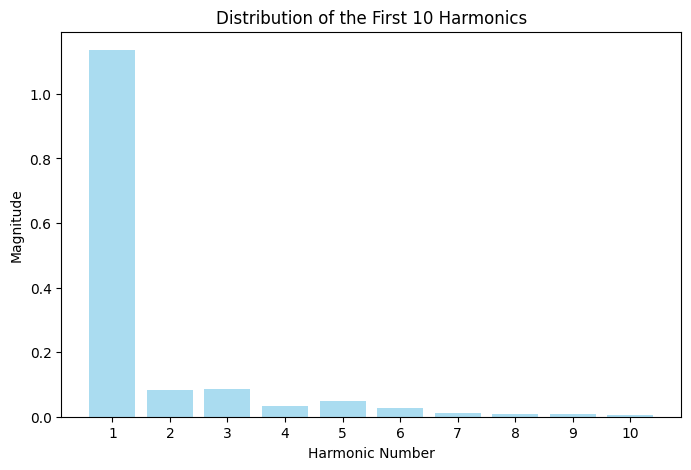

S (computed): 36.88000047690695
S (suggested change): 36.88000017440694
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_322_1.png


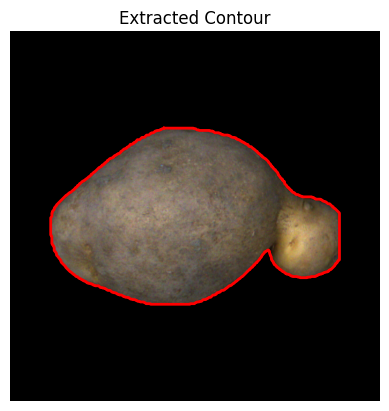

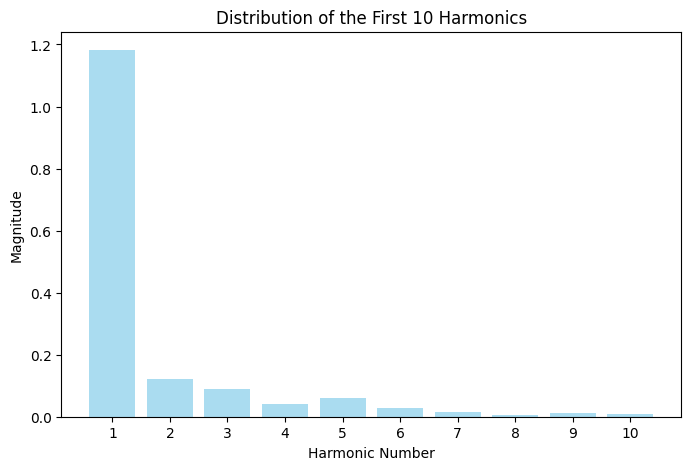

S (computed): 46.200045768542466
S (suggested change): 46.20004546604247
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_32_1.png


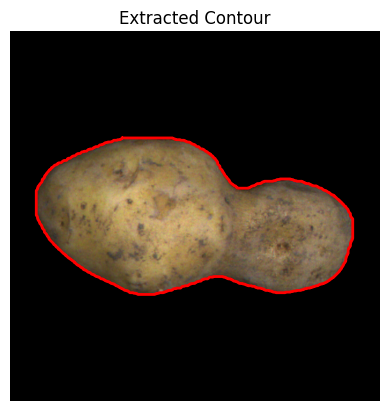

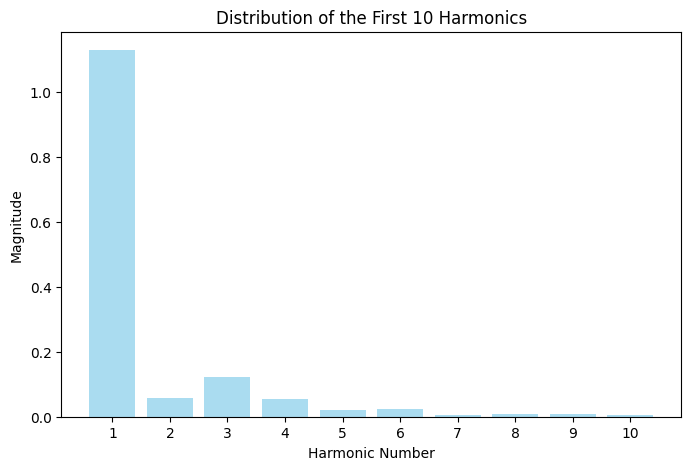

S (computed): 34.03228178411448
S (suggested change): 34.03228148161448
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_132_2.png


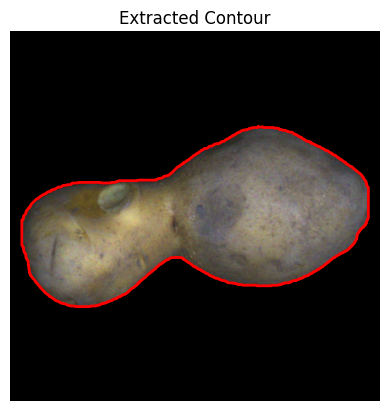

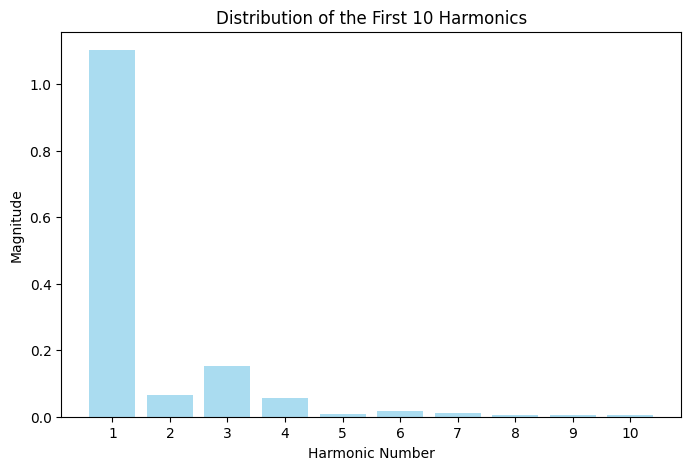

S (computed): 31.689964676369073
S (suggested change): 31.689964373869074
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_184_Potato_11.png


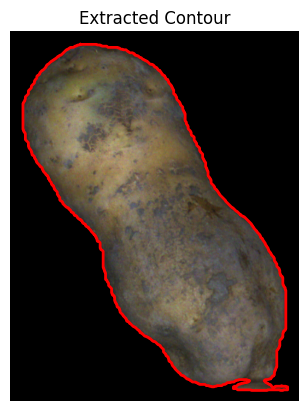

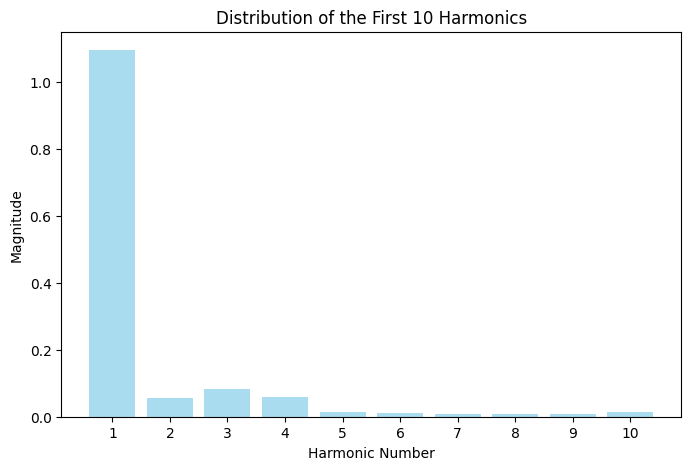

S (computed): 40.25965817393585
S (suggested change): 40.25965787143585
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_2_466_13.png


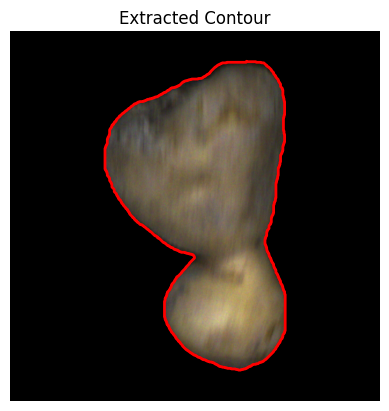

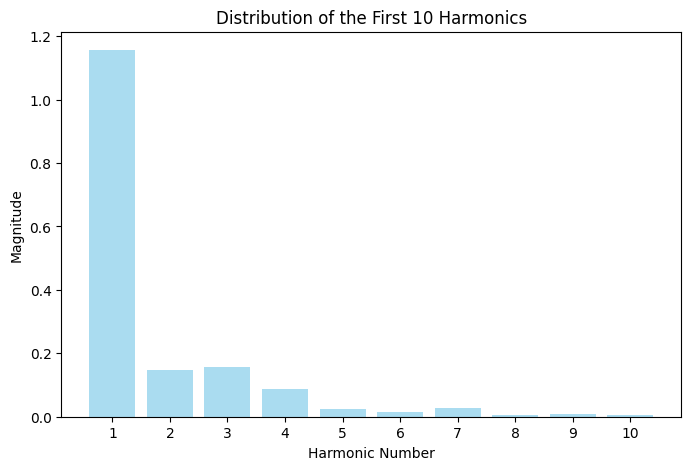

S (computed): 44.63408432564722
S (suggested change): 44.634084023147224
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_122_0.png


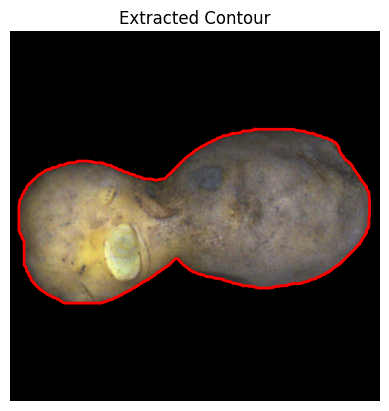

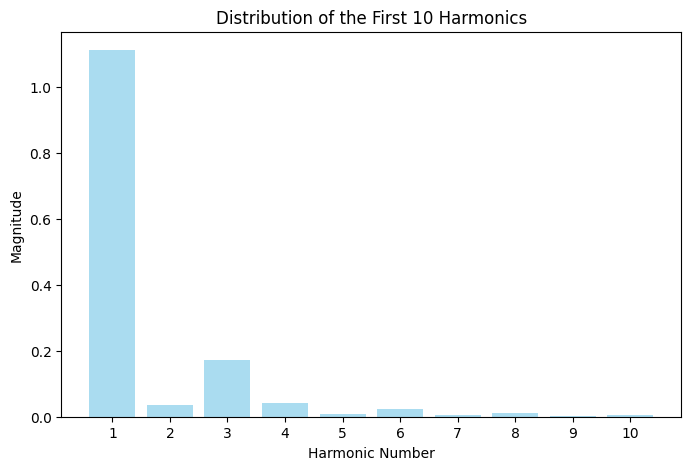

S (computed): 31.4711269035898
S (suggested change): 31.471126601089804
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_120_2.png


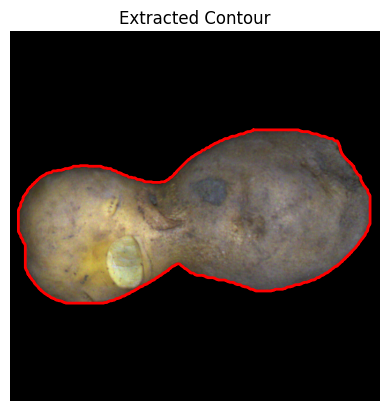

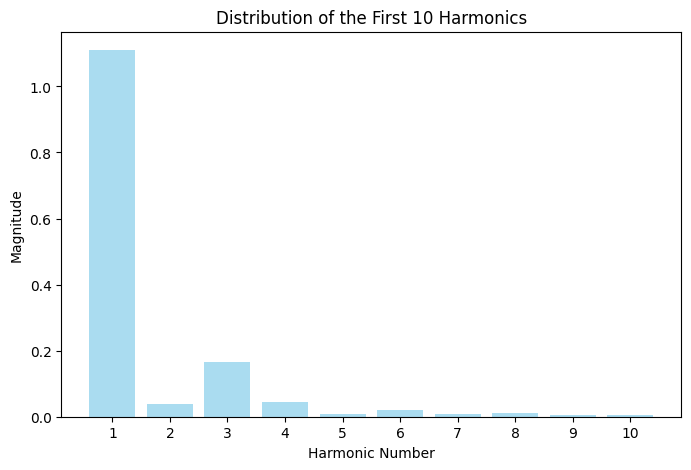

S (computed): 29.86644755032347
S (suggested change): 29.866447247823473
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_160_8.png


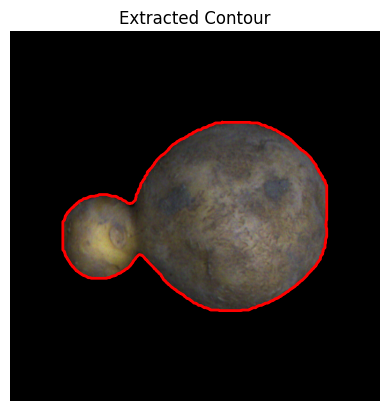

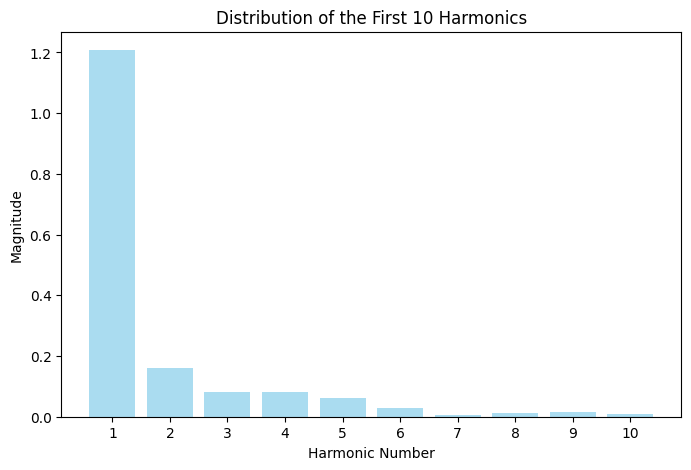

S (computed): 49.65819322991636
S (suggested change): 49.65819292741635
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_30_3.png


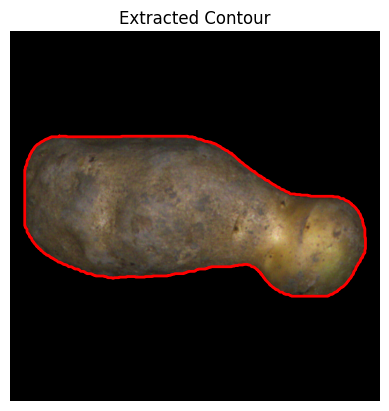

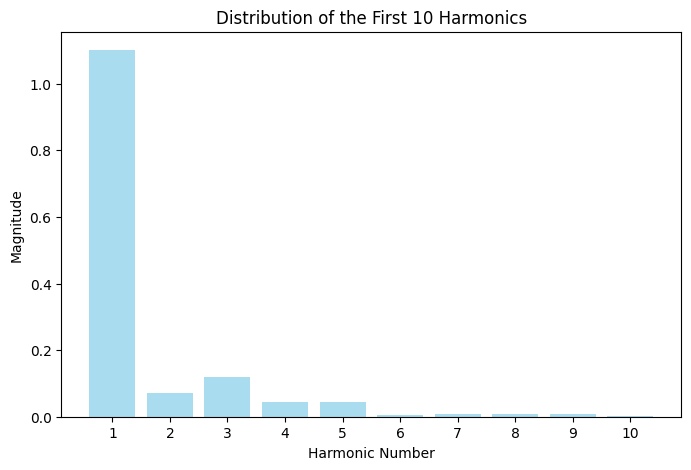

S (computed): 30.803670496787166
S (suggested change): 30.803670194287164
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_2_468_0.png


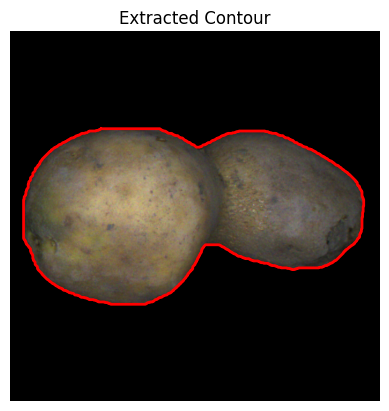

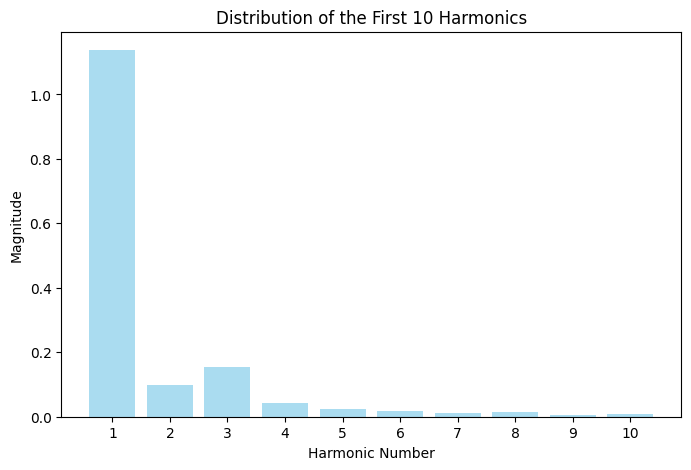

S (computed): 36.896196462187156
S (suggested change): 36.89619615968716
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_168_4.png


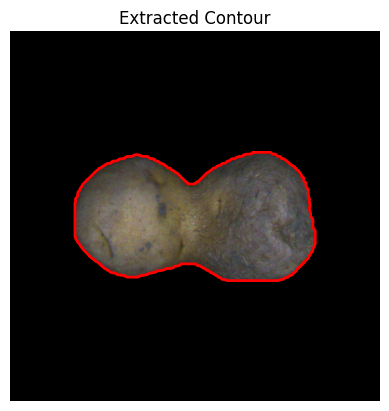

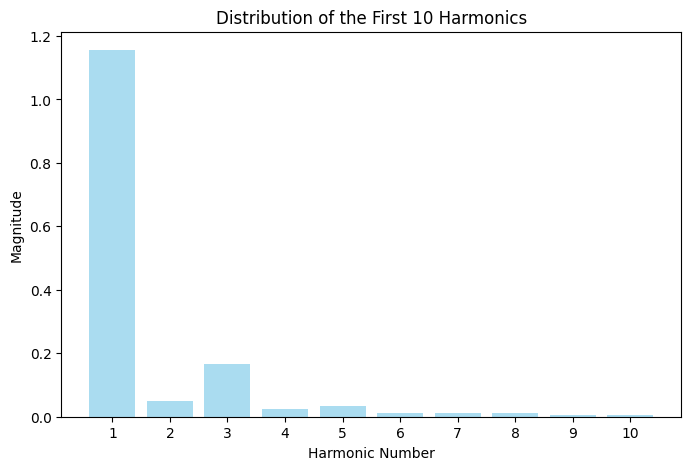

S (computed): 33.186324895761565
S (suggested change): 33.18632459326157
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_272_7.png


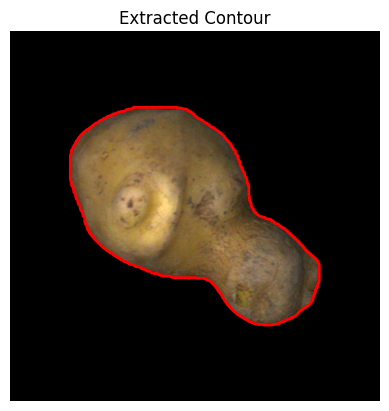

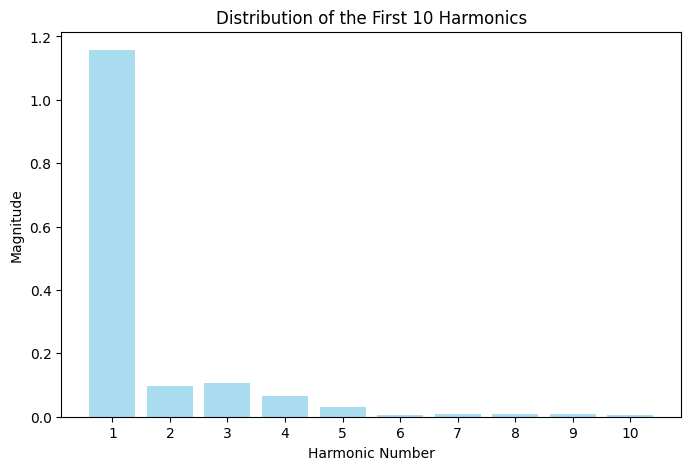

S (computed): 32.87840154099213
S (suggested change): 32.878401238492124
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_102_3.png


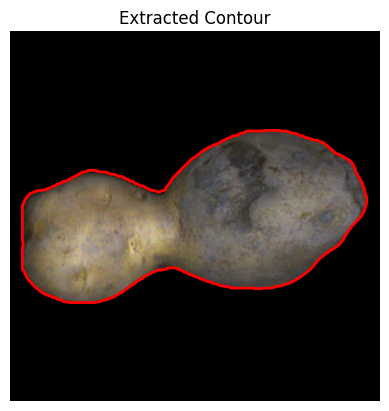

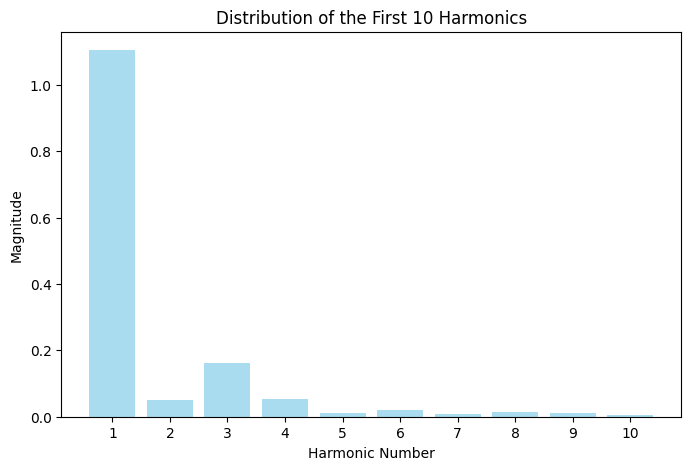

S (computed): 38.41218620609577
S (suggested change): 38.41218590359577
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_2_470_12.png


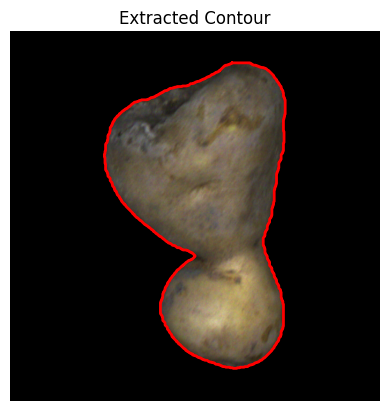

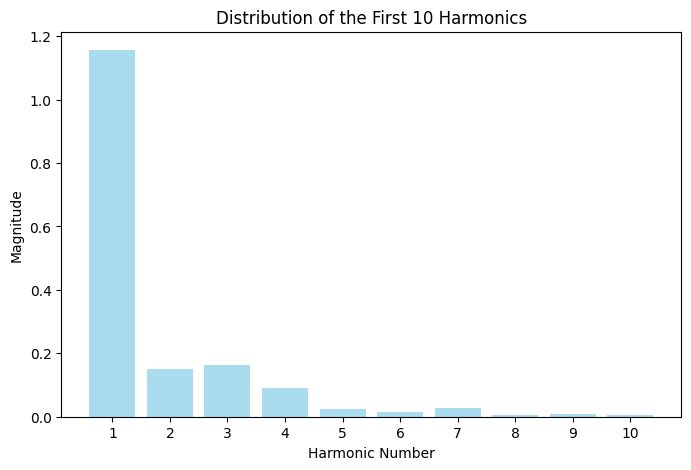

S (computed): 44.8926158978781
S (suggested change): 44.892615595378096
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_166_12.png


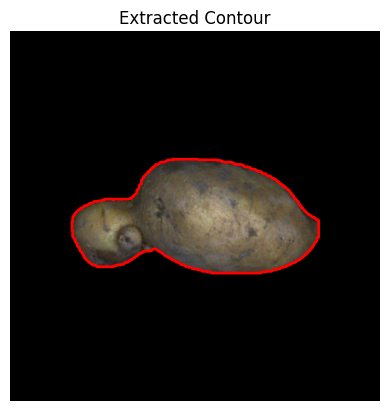

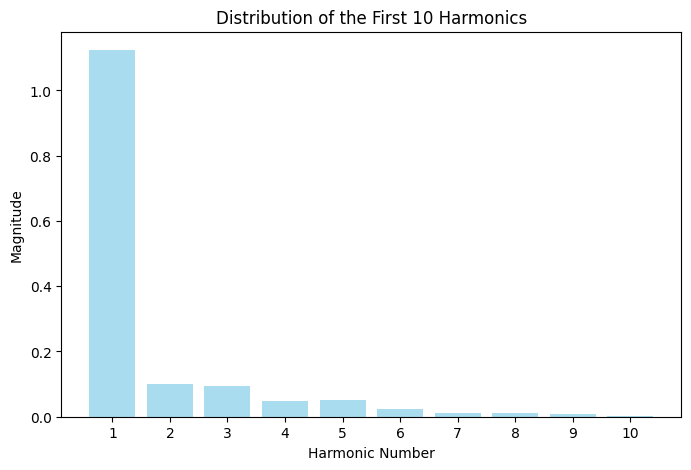

S (computed): 38.20187067512556
S (suggested change): 38.201870372625564
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_46_0.png


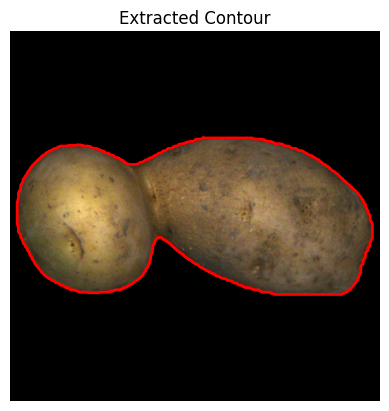

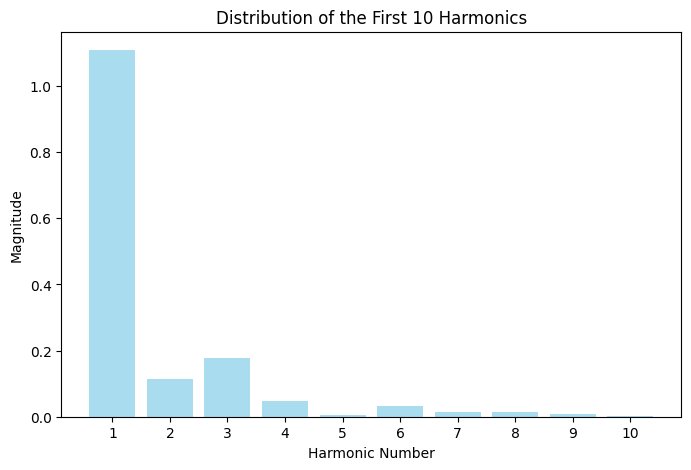

S (computed): 39.369353521177715
S (suggested change): 39.369353218677716
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_188_16.png


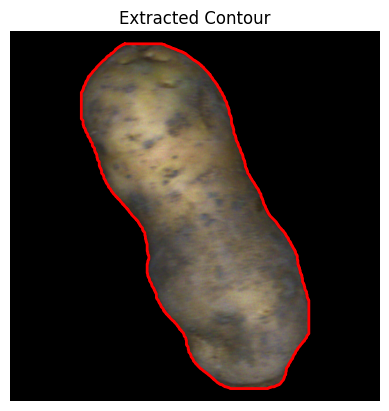

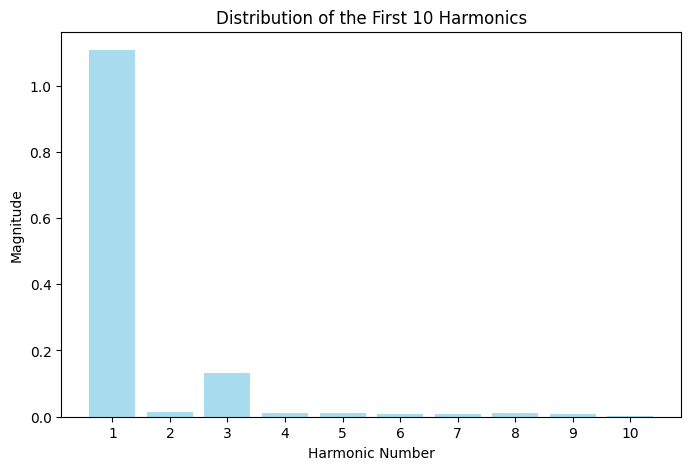

S (computed): 25.60549300971589
S (suggested change): 25.60549270721589
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_122_14.png


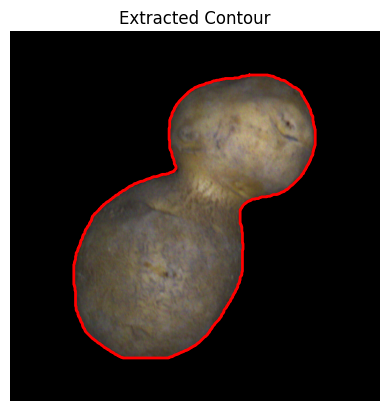

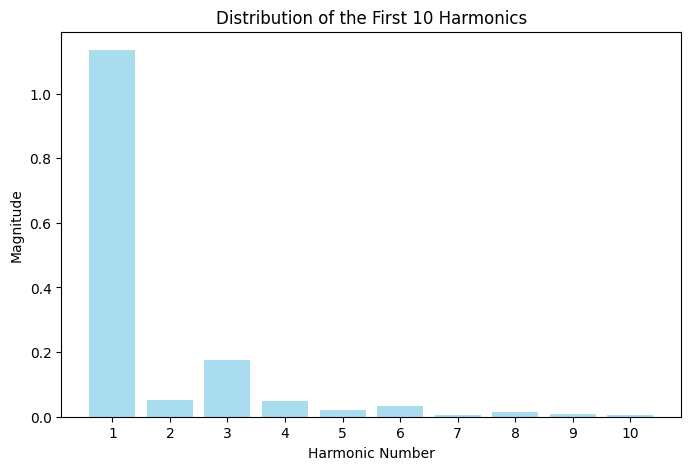

S (computed): 41.7039564795316
S (suggested change): 41.7039561770316
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_126_3.png


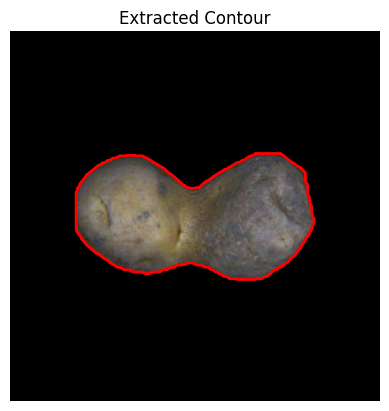

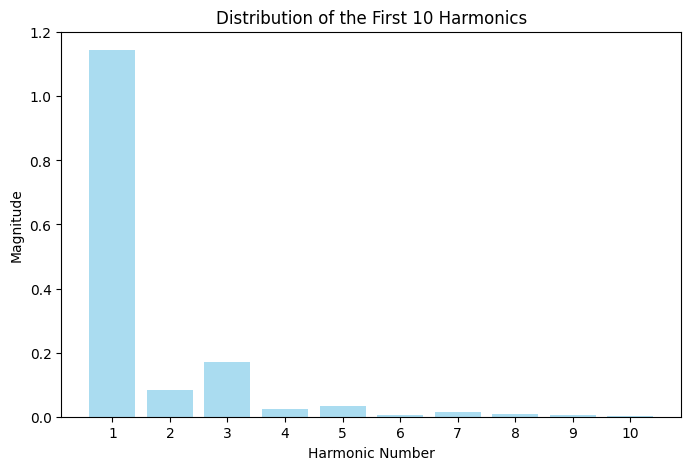

S (computed): 29.70336916429432
S (suggested change): 29.703368861794317
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_130_6.png


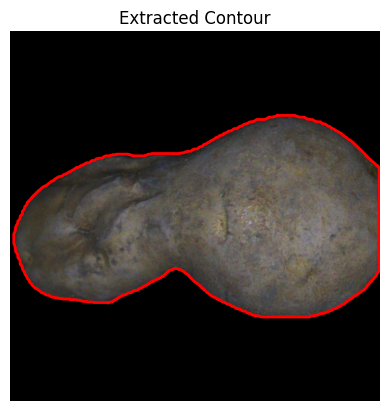

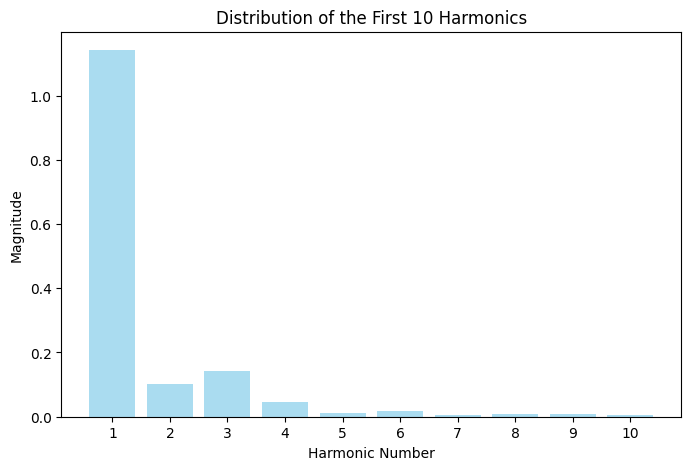

S (computed): 32.10307892094795
S (suggested change): 32.10307861844795
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_154_7.png


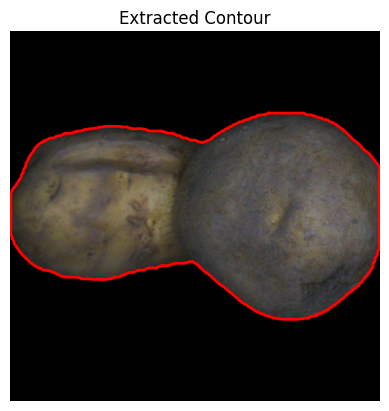

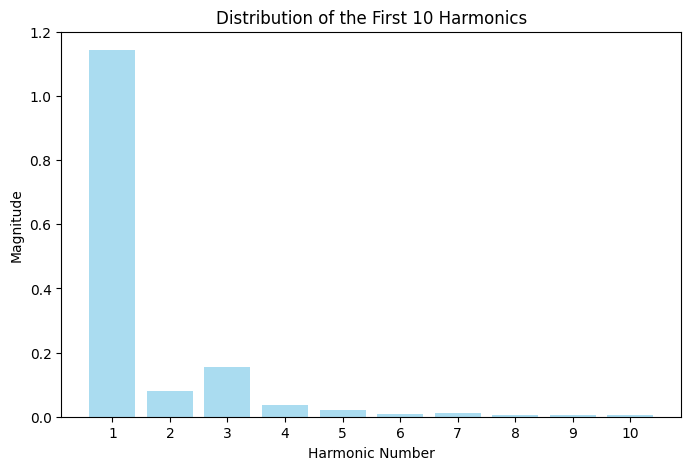

S (computed): 29.10270721335538
S (suggested change): 29.10270691085538
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_38_4.png


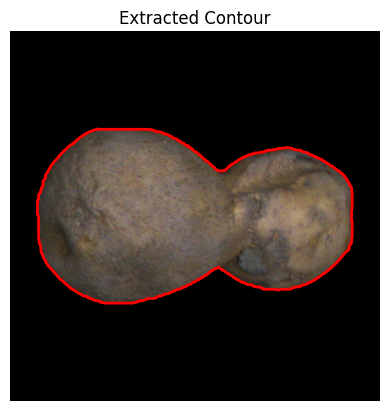

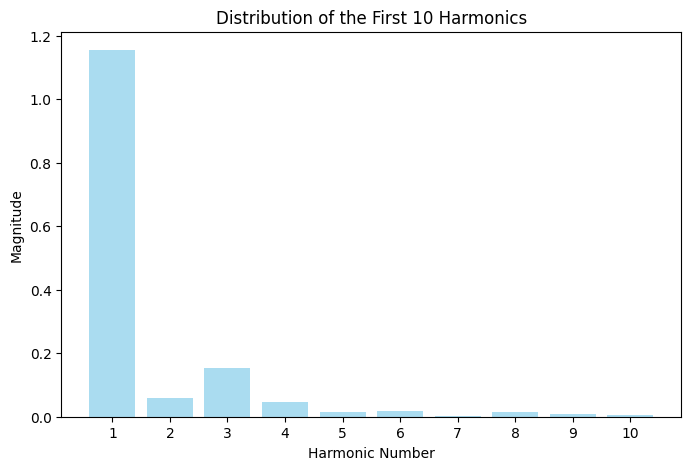

S (computed): 33.759556559207894
S (suggested change): 33.75955625670789
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_106_7.png


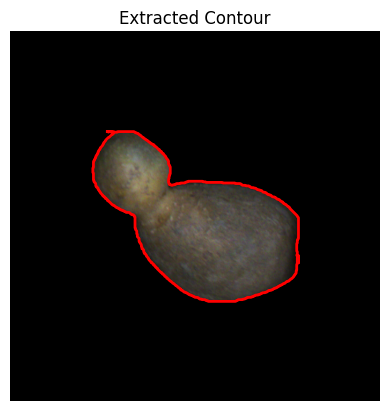

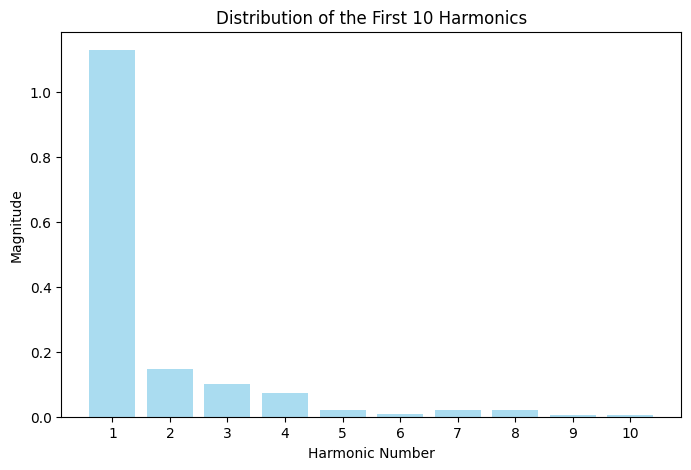

S (computed): 41.48293701789875
S (suggested change): 41.48293671539874
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_184_Potato_16.png


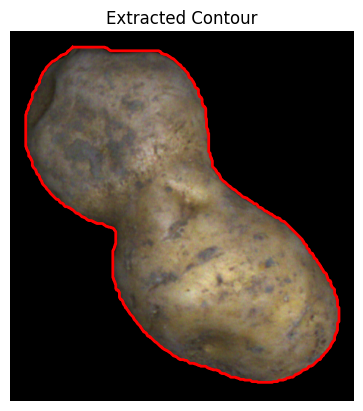

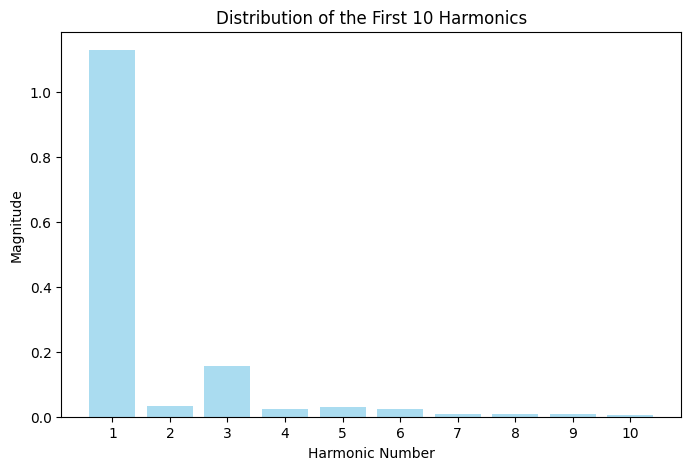

S (computed): 34.408159831417656
S (suggested change): 34.40815952891766
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_2_428_Potato_9.png


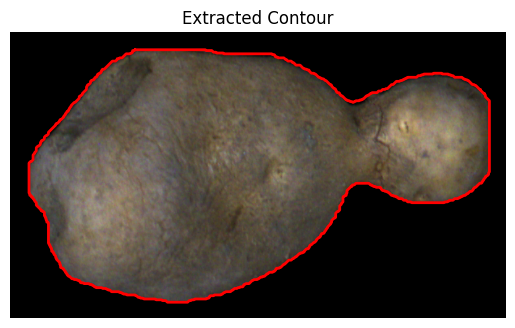

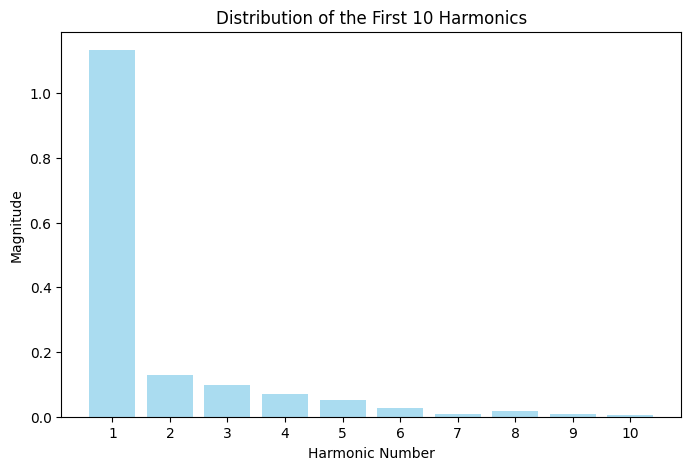

S (computed): 45.42858655782505
S (suggested change): 45.428586255325044
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_168_3.png


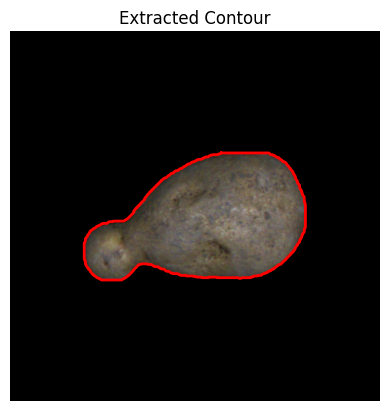

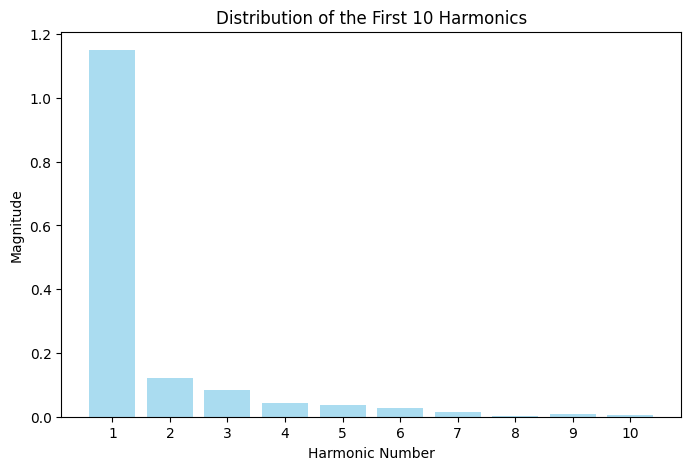

S (computed): 35.35787134134024
S (suggested change): 35.357871038840244
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_168_5.png


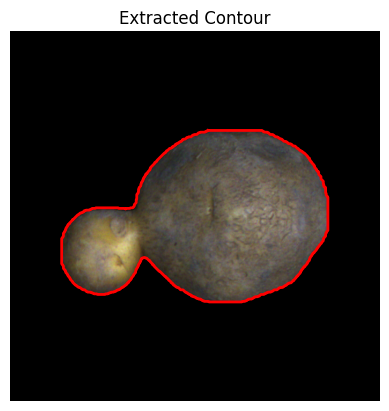

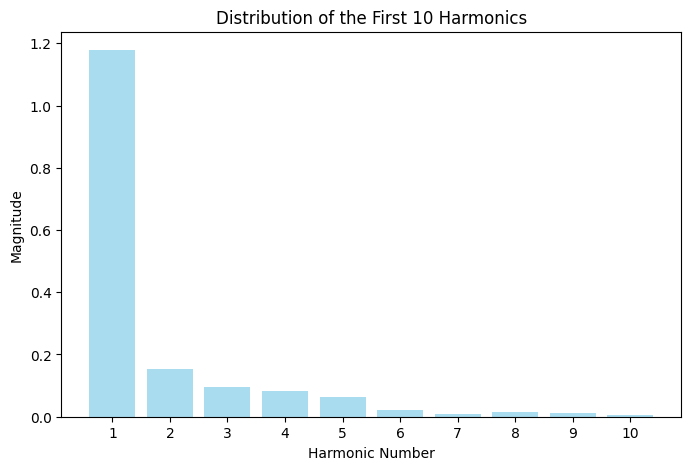

S (computed): 47.39224018410654
S (suggested change): 47.39223988160654
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_184_Potato_14.png


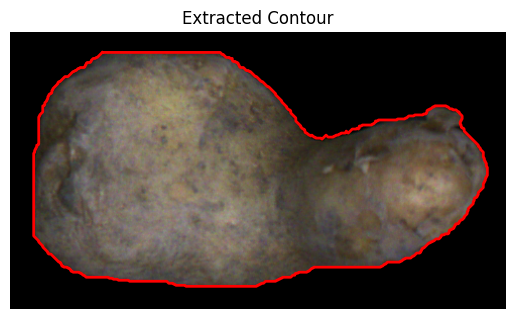

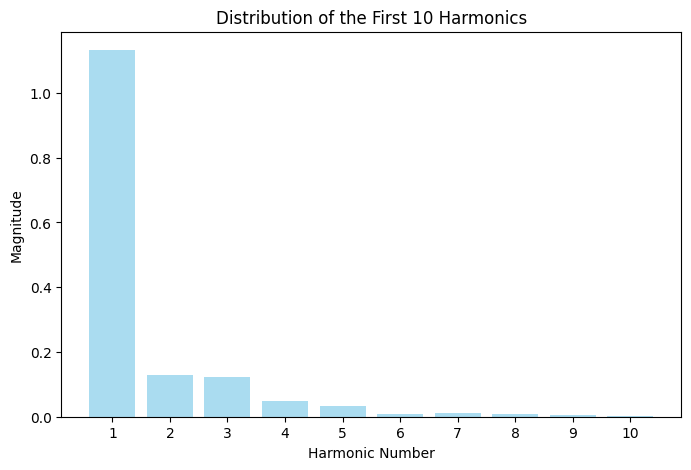

S (computed): 31.001685863064797
S (suggested change): 31.0016855605648
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_190_13.png


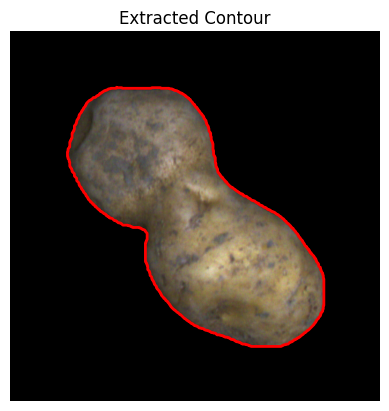

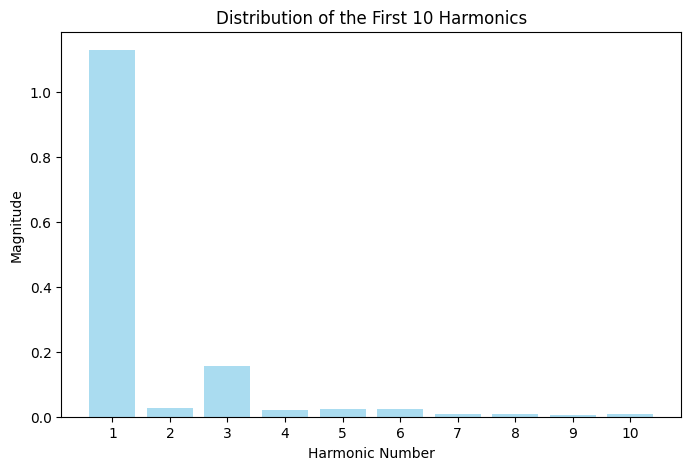

S (computed): 33.48496398038854
S (suggested change): 33.484963677888544
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_344_11.png


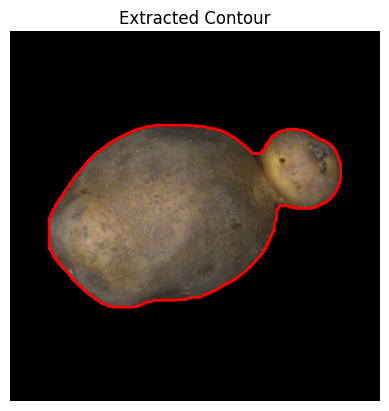

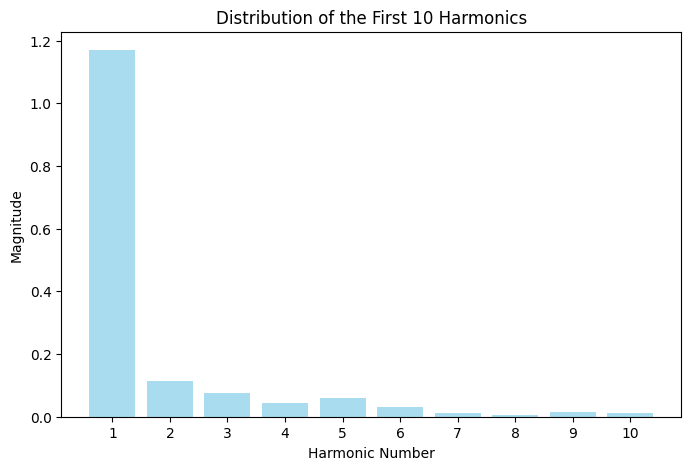

S (computed): 52.07562181962811
S (suggested change): 52.07562151712812
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_108_3.png


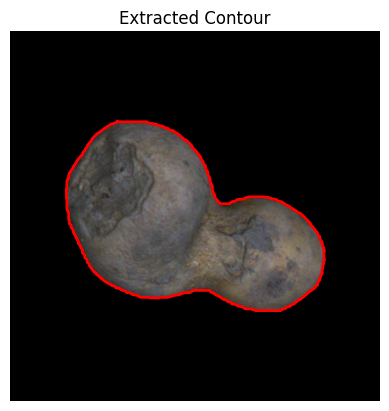

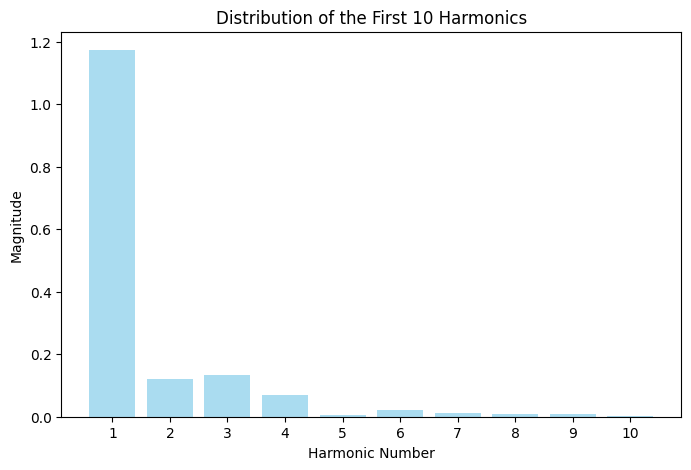

S (computed): 34.12433480203112
S (suggested change): 34.12433449953112
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_110_Potato_0.png


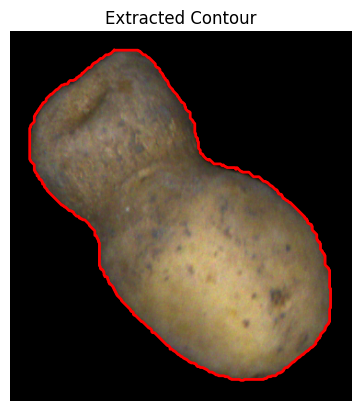

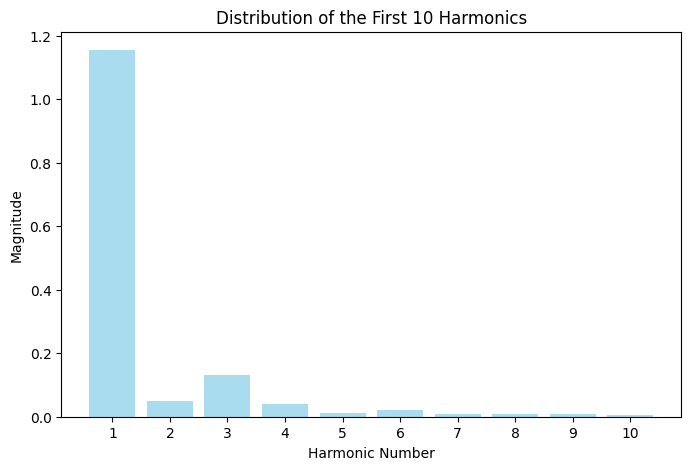

S (computed): 33.52156442561067
S (suggested change): 33.52156412311067
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_2_428_Potato_3.png


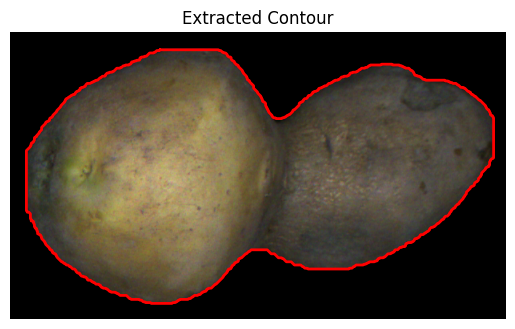

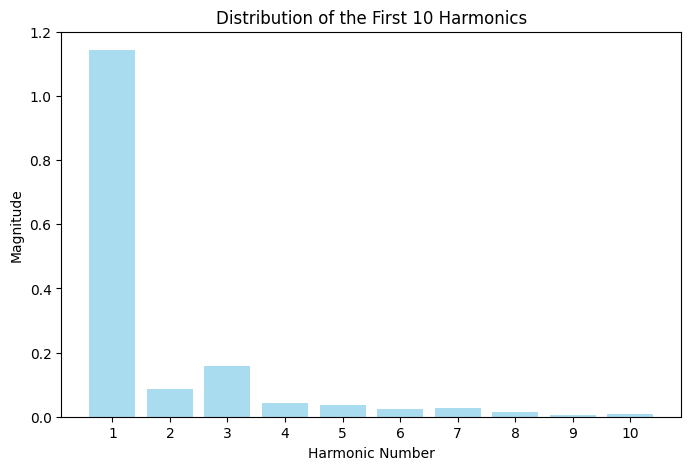

S (computed): 46.89360536267918
S (suggested change): 46.89360506017918
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_102_13.png


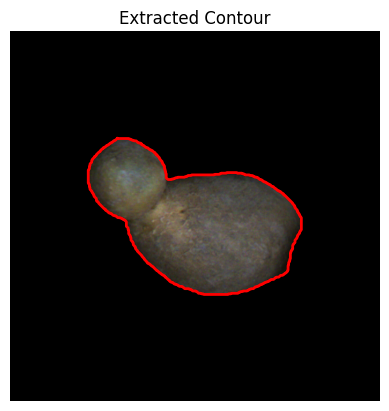

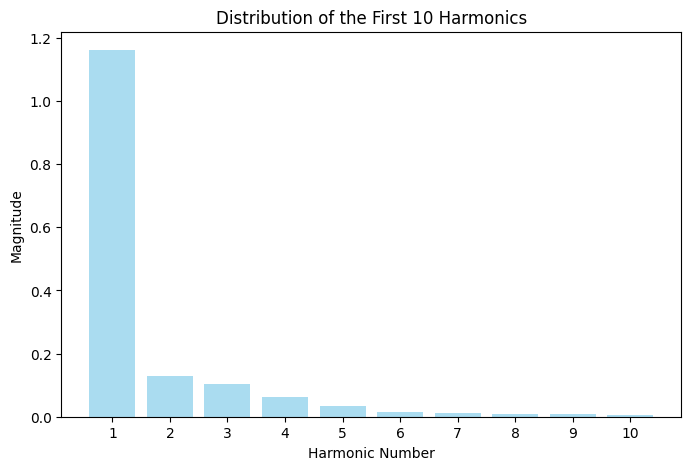

S (computed): 37.521776760711454
S (suggested change): 37.521776458211455
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_3_190_12.png


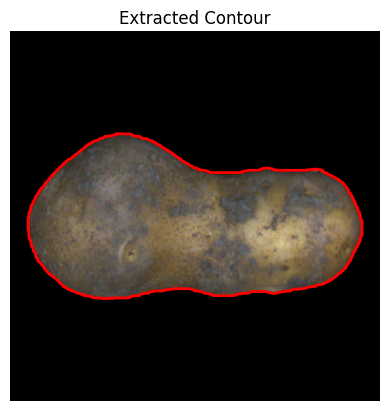

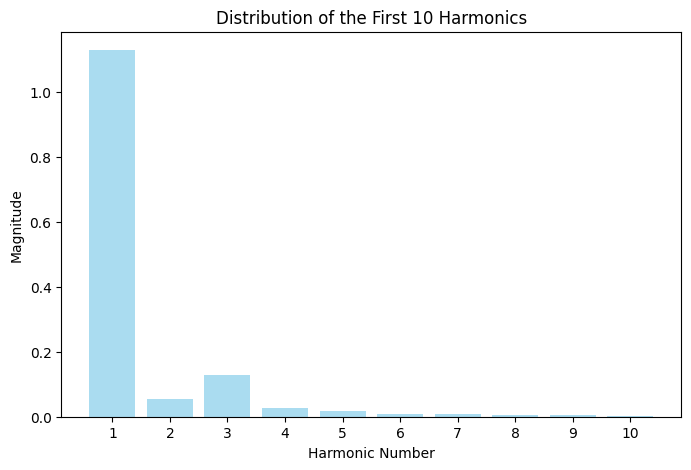

S (computed): 21.10898371844362
S (suggested change): 21.108983415943626
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_2_462_4.png


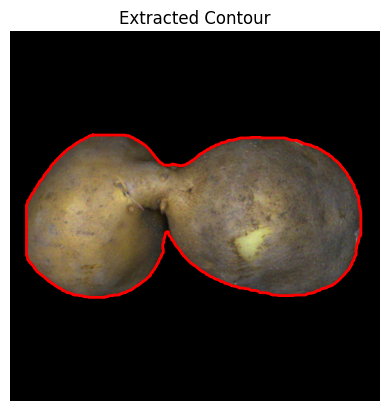

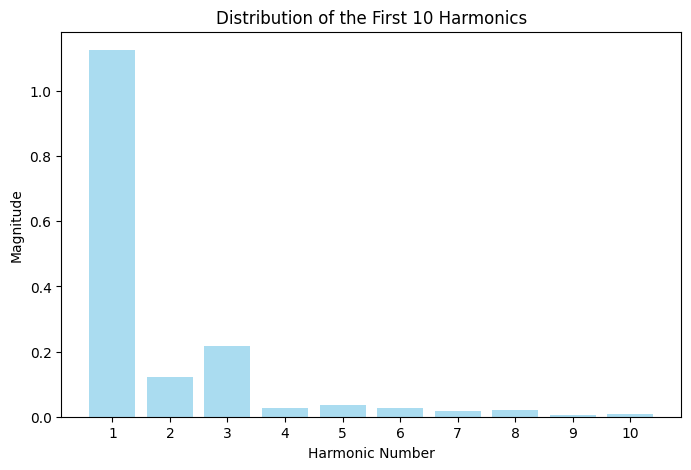

S (computed): 49.39686960868349
S (suggested change): 49.39686930618349
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_120_16.png


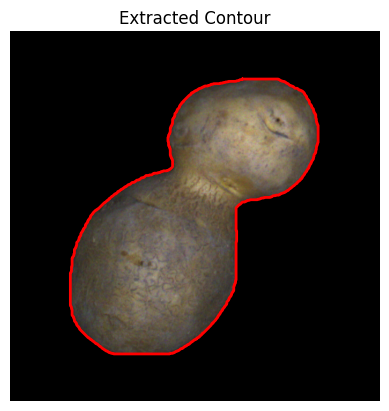

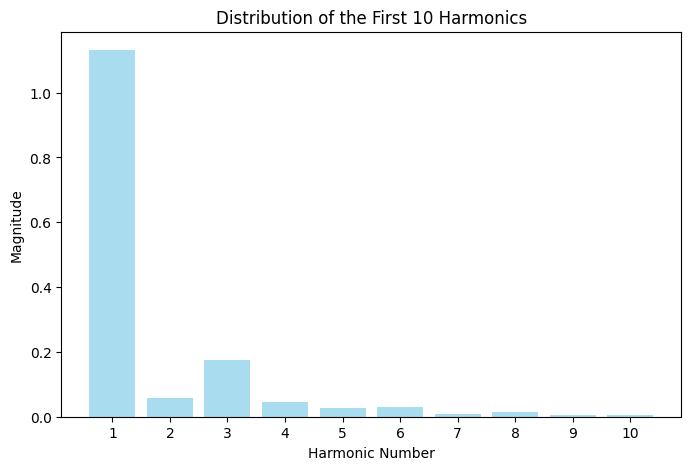

S (computed): 39.19543633002938
S (suggested change): 39.195436027529375
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_4_110_Potato_11.png


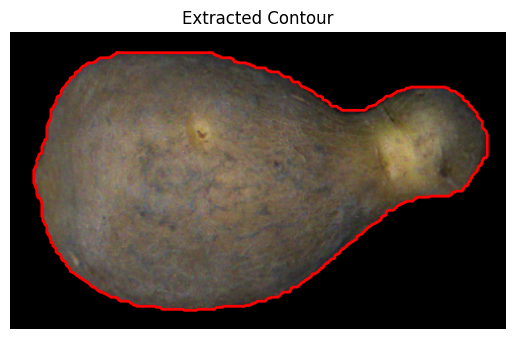

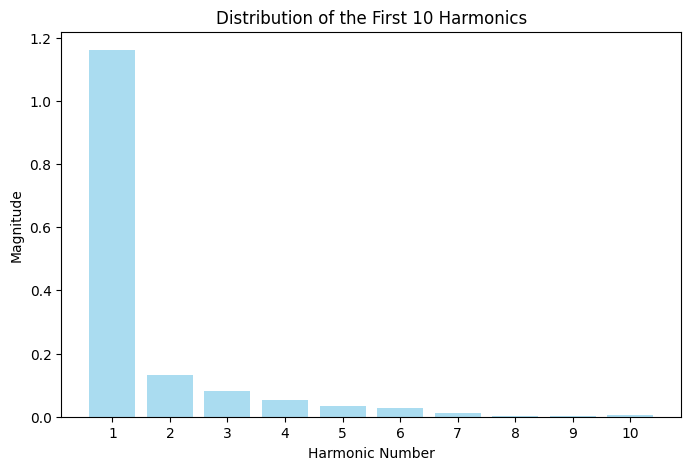

S (computed): 30.179517839144978
S (suggested change): 30.179517536644983
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_130_12.png


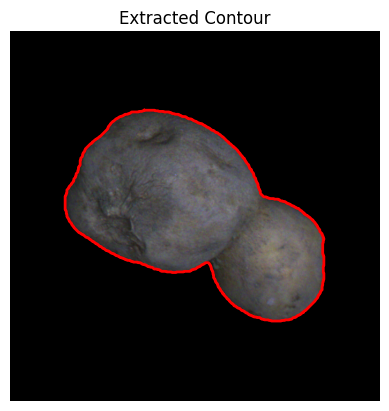

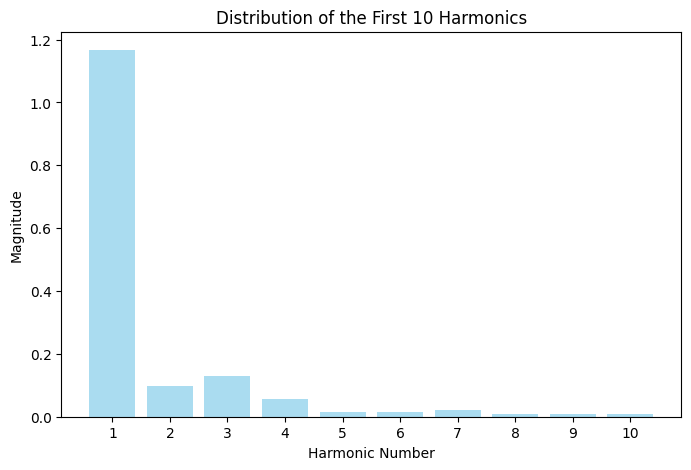

S (computed): 39.95832441284238
S (suggested change): 39.958324110342375
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_168_10.png


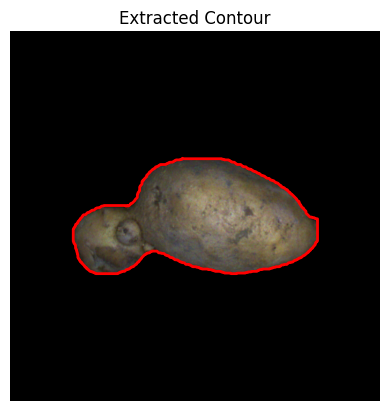

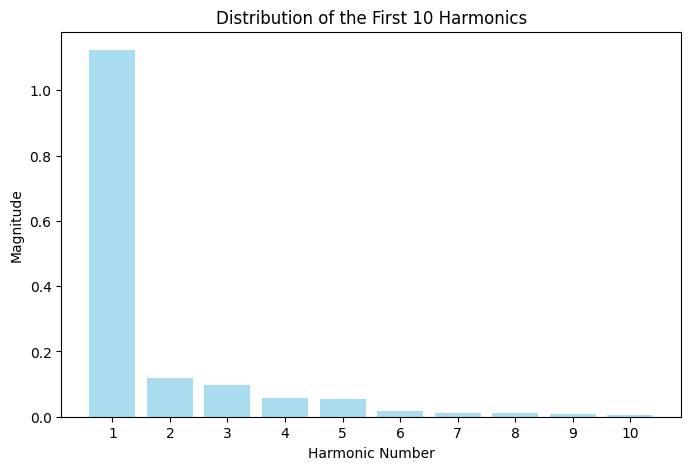

S (computed): 40.27371383564451
S (suggested change): 40.27371353314451
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_120_0.png


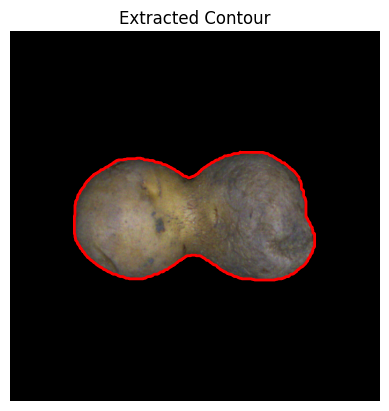

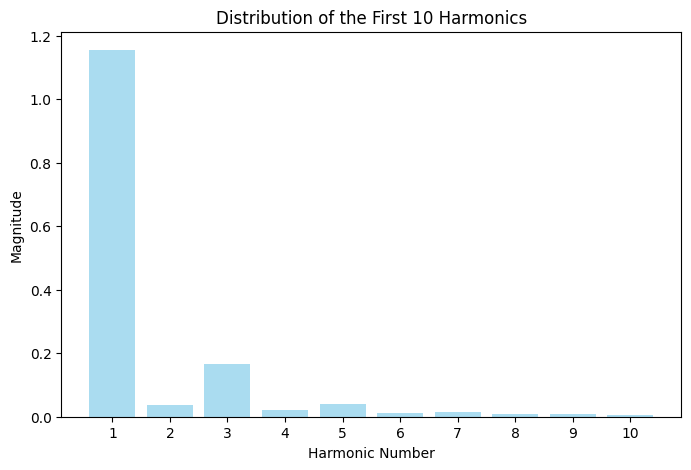

S (computed): 34.73563638188229
S (suggested change): 34.73563607938229
------------------------------------------------------------
Processing image: /home/mishkat/Documents/malformed_potato/5_classes_malformed/bottleneck/sd_malformed_12_2_1_16_2.png


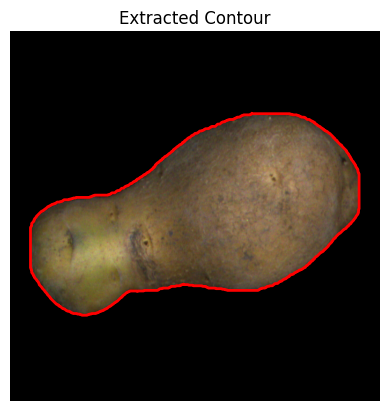

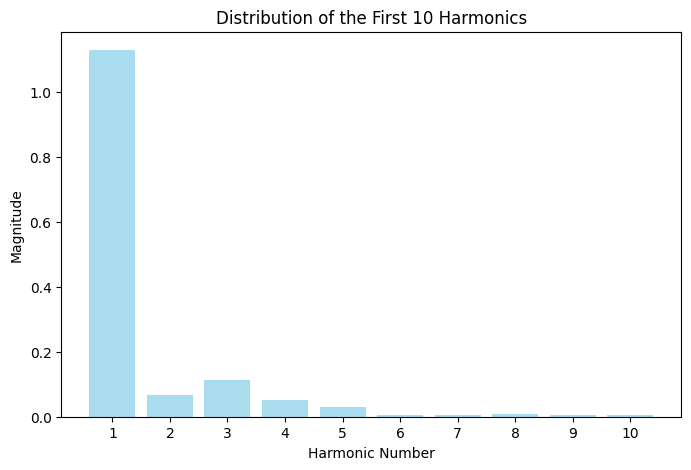

S (computed): 25.85206873666677
S (suggested change): 25.85206843416677
------------------------------------------------------------


In [8]:
# Process images in the specified folder
process_images_in_folder(folder_path)

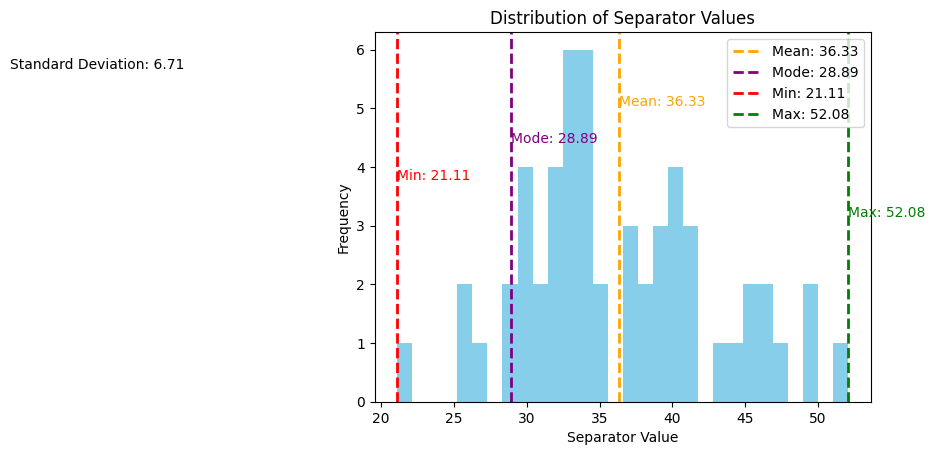

In [9]:
# Assuming separator_values_1 is a list of separator values
plt.hist(separator_values_compute_s, bins=30, color='skyblue')

# Calculate mean, standard deviation, mode, min, and max
mean_value = statistics.mean(separator_values_compute_s)
std_dev = statistics.stdev(separator_values_compute_s)
mode_value = statistics.mode(separator_values_compute_s)
min_value = min(separator_values_compute_s)
max_value = max(separator_values_compute_s)

# Add vertical lines for mean, mode, min, and max
plt.axvline(mean_value, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mode_value, color='purple', linestyle='--', linewidth=2, label=f'Mode: {mode_value:.2f}')
plt.axvline(min_value, color='red', linestyle='--', linewidth=2, label=f'Min: {min_value:.2f}')
plt.axvline(max_value, color='green', linestyle='--', linewidth=2, label=f'Max: {max_value:.2f}')

# Add text annotations for mean, standard deviation, mode, min, and max
plt.text(mean_value, plt.ylim()[1] * 0.8, f'Mean: {mean_value:.2f}', color='orange')
plt.text(mode_value, plt.ylim()[1] * 0.7, f'Mode: {mode_value:.2f}', color='purple')
plt.text(min_value, plt.ylim()[1] * 0.6, f'Min: {min_value:.2f}', color='red')
plt.text(max_value, plt.ylim()[1] * 0.5, f'Max: {max_value:.2f}', color='green')
plt.text(0.5, plt.ylim()[1] * 0.9, f'Standard Deviation: {std_dev:.2f}', ha='center')

# Add labels, title, and legend
plt.xlabel("Separator Value")
plt.ylabel("Frequency")
plt.title("Distribution of Separator Values")
plt.legend()
plt.show()